# 2025 Qiskit Fall Fest - Computing the Ground State Energy of Molecules by Sampling-based Quantum Diagonalizaton

- QPU time: ~2min
- Difficulty level: Advanced
- Number of exercises: 6

<div class="alert alert-info">
This notebook is a practical implementation of the concepts taught in the <a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms" target="_blank">Quantum Diagonalization Algorithms course</a> on IBM Quantum Learning, more focused on comparing sampling capacities of different ansatz. For a deeper theoretical understanding of the methods used here, please refer to the course materials.
<br><br>
You will also find it helpful to reference:
    
* <a href="https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-quantum-diagonalization">Sample-based quantum diagonalization of a chemistry Hamiltonian Tutorial</a>

* <a href="https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-krylov-quantum-diagonalization">Sample-based Krylov quantum diagonalization of a fermionic lattice model Tutorial</a>

* <a href="https://github.com/qiskit-community/qgss-2025/blob/main/lab-3/lab3.ipynb">QGSS 2025 Lab 3 notebook</a>
</div>

## Learning Objectives:
-   Understand the Sample-based Quantum Diagonalization (SQD) methods.
-   Analyze and compare how the choice of ansatz and initial parameters affects on SQD result.
-   Explore the potential of SKQD, a combination of a SQD and Krylov Diagonalization.

## Useful pre-study resources (for organizers)
- [Mapping Computational Problems onto Quantum Circuits with Kevin Sung: Qiskit Summer School 2024](https://www.youtube.com/watch?v=TyFU6r8uEsE), 2024
- [A Deep Dive Into Sample-Based Quantum Diagonalization Methods: Javier Robledo Moreno | QGSS 2025](https://www.youtube.com/watch?v=VZadH9L9ZIM&list=PLOFEBzvs-VvoIfbpOb_geVnwFmbW6ij0m&index=11), 2025
- [SQD for Physics | Designing New Algorithms with Qiskit](https://www.youtube.com/watch?v=4QAjIACBt1k), 2025
- [SQD for Chemistry | Designing New Algorithms with Qiskit](https://www.youtube.com/watch?v=9yHU7UjJ_yI), 2025

## 0. Introduction

Finding the eigenvalues of large Hamiltonian matrices is a fundamental challenge in quantum mechanics and a key application for quantum computers. While classical exact diagonalization becomes computationally intensive for even small-size molecules, subspace methods offer a powerful alternative. By projecting the Hamiltonian onto a smaller, carefully chosen subspace that captures the essential physics, we can solve the problem on a classical computer. The crucial question then becomes: how do we construct this "useful" subspace?

This notebook explores and compares two distinct quantum approaches for constructing this subspace to find the ground state energy of the dinitrogen ($N_2$) molecules:


1.  Sample-based Quantum Diagonalization (SQD): This is a sampling-based approach where a quantum circuit, or ansatz, is used to prepare a trial state. By measuring this state in the computational basis, we sample a set of important configurations that are then used to define the subspace. The quality of the prepared quantum state is critical for the SQD method. A well-designed ansatz that reflects the underlying chemistry of the problem can generate a much more effective subspace than a generic one. To demonstrate this, we will systematically compare the performance of three different ansatz strategies for SQD, observing how accuracy improves with a more informed approach.

2. Sample-based Krylov Quantum Diagonalization (SKQD) extends SQD by introducing a Krylov subspace. Instead of sampling from a trial state prepared by a general parameterized ansatz, SKQD begins with a reference state (in a chemistry problem, this is typically a Hartree-Fock state) and iteratively applies the Hamiltonian to generate a Krylov space, which is a powerful method for approximating the lowest eigenvalues of a matrix. The states sampled from this unitary Krylov space form a smaller, more effective subspace than those from a general parameterized ansatz and offer convergence guarantees.


## 1. Environment Setup

Before we begin our calculation, we need to prepare our computational environment. This involves importing all the necessary Python libraries for both classical chemistry calculations and quantum circuit execution, and connecting to the IBM Quantum platform to use real QPU.

 **Note**: Please make sure you have installed the latest version of Qiskit and the relevant packages.

In [1]:
# Install the necessary packages

#%pip install -U ffsim 'qiskit[visualization]' qiskit-aer qiskit-ibm-runtime qiskit-addon-sqd

In [2]:

import itertools
import warnings
from functools import partial

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pyscf
import pyscf.cc
import pyscf.mcscf
import scipy as sp

# Qiskit-related imports
import ffsim
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import BitArray
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
)
from qiskit_ibm_runtime.fake_provider import (
    FakeFez, 
    FakeTorino, 
    FakeBrisbane
)

# SQD addon and utilities
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

warnings.filterwarnings("ignore")

#### Connecting to the IBM Quantum Hardware
To run our experiments on real quantum hardware, we first need to authenticate. The `QiskitRuntimeService` class handles the connection to the IBM Quantum platform. 

In the following cell, we initialize the service. You may need to enter your API token if you have not saved it previously. Once the service is active, we will select a backend to run our jobs on. For this notebook, we will use `service.least_busy()` to automatically select an available device with the shortest queue.

In [3]:
crn=""
your_token = ""

#QiskitRuntimeService.save_account(
#    channel="ibm_quantum_platform",
#    token=your_token,
#    instance=crn,
#    overwrite=True,
#    set_as_default=True
#)

service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_kingston')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_torino')>]

Let's setting a backend and a `Sampler` you will use through this lab.

In [4]:

#To run on a real quantum system
backend = service.least_busy(simulator=False)


#If you want an ideal simulation
#backend=AerSimulator()

#for a noisy simulation
#backend = AerSimulator.from_backend(backend)
#backend = FakeBrisbane()



# Initialize a Sampler with backend

sampler= Sampler(mode=backend)

backend

<IBMBackend('ibm_kingston')>

## 2. Problem Definition: The $N_2$ Molecule


### 2.1 Classical quantum chemistry calculation

To test and compare our quantum algorithms, we will use the dinitrogen ($N_2$) molecule, a common benchmark system in quantum chemistry. Before running quantum algorithms, let's use `PySCF` to perform a classical quantum chemistry calculations:

* [Self-Consistent Field (SCF)](https://pyscf.org/user/scf.html) calculation: We first perform an SCF calculation to find the Hartree-Fock state (a baseline approximation of the ground state). This also provides the one- and two-body integrals (`hcore` and `eri`), which we will later use to construct the Hamiltonian.
* [Full Configuration Interaction (FCI)](https://pyscf.org/user/ci.html#full-configuration-interaction-fci) calculation: We then run an FCI calculation within the active space (known as CASCI) to get the numerically "exact" ground state energy for our chosen basis set, which serves as our benchmark.
* [Coupled-Cluster Single and Doubles (CCSD)](https://pyscf.org/user/cc.html) calculation: We also run a CCSD calculation to obtain the [t-amplitudes](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.79.291#s3) (t1 and t2). These amplitudes, which quantify electron excitations, provide an excellent, physically-motivated initial guess for the parameters of our chemistry-inspired ansatz. 

**Note** For more details of each chemical method and `PySCF` itself, please refer [The Python-based Simulations of Chemistry Framework (PySCF)](https://arxiv.org/abs/1701.08223), the original paper about the `pyscf` package for your own deeper study. In general, "Modern Quantum Chemistry: Introduction to Advanced Electronic Structure Theory" by Attila Szabo and Neil S. Ostlund is recommended as a good textbook to learn about each method in details, but this can be a graduate level study, and we won't cover each details here. 

In [5]:
#Define molecule

mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="sto-6g",
    symmetry="dooh"

)

We will now define an active space. This technique involves "freezing" the core orbitals (electrons very close to the nuclei) and discarding the highest-energy virtual orbitals, as they contribute less to the chemical bonding and correlation. This allows us to focus our simulation on the most important valence electrons, reducing the number of qubits required. For this $N_2$ problem, we will simulate 8 spatial orbitals with 10 active electrons, which translates to a 16-qubit problem. 


<div class="alert alert-success">
    <h4>Exercise 1: Defining the Active Space and get a molecular property of N2</h4>
    <p>For the N₂ molecule with a <code>sto-6g</code> basis set, there are 10 total molecular orbitals. To reduce computational cost, we will "freeze" the two lowest-energy core orbitals and use the remaining 8 orbitals as our <b>active space</b>.</p>
    <p>In the code cell below, calculate and fill in the following variables:</p>
    <ul>
        <li><code>num_orbitals</code>: The number of spatial orbitals in the active space.</li>
        <li><code>n_electrons</code>: The total number of electrons in the active space.</li>
        <li><code>num_elec_a</code>: The number of alpha (spin-up) electrons in the active space.</li>
        <li><code>num_elec_b</code>: The number of beta (spin-down) electrons in the active space.</li>
    </ul>
    <p><b>Hint:</b> <code>scf.mo_occ</code> is an array containing the occupation (0, 1, or 2) of each molecular orbital. You can use this array, indexed by the <code>active_space</code>, to count the electrons. Since dinitrogen is a closed-shell system, the number of alpha and beta electrons will be equal.</p>
</div>

In [6]:
# --- Perform Self-Consistent Field (SCF) Calculation ---
scf = pyscf.scf.RHF(mol).run()

n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
num_orbitals = len(active_space)

# --- Determine Number of Alpha and Beta Electrons ---
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
nelec = (num_elec_a, num_elec_b)
num_qubits = 2 * num_orbitals

print(f"Number of active spatial orbitals: {num_orbitals}")
print(f"Number of active electrons: {n_electrons}")
print(f"Number of alpha electrons: {num_elec_a}")
print(f"Number of beta electrons: {num_elec_b}")
print(f"Number of qubits: {num_qubits}")


converged SCF energy = -108.464957764796
Number of active spatial orbitals: 8
Number of active electrons: 10
Number of alpha electrons: 5
Number of beta electrons: 5
Number of qubits: 16


Then, FCI calculation to get the `exact_fci_energy` of our molecule.

In [7]:
# Calculate molecular integrals and FCI benchmark

cas = pyscf.mcscf.CASCI(scf, num_orbitals, nelec)
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)
fci_result = cas.run(mo)
exact_fci_energy = fci_result.e_tot

print(f"\nExact total ground state energy (FCI): {exact_fci_energy:.6f} Ha")


CASCI E = -108.595987350986  E(CI) = -32.4115475088426  S^2 = 0.0000000

Exact total ground state energy (FCI): -108.595987 Ha


Finally, a CCSD calculation to get a `t1` and `t2`

In [8]:
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run(verbose=0)

t1 = ccsd.t1
t2 = ccsd.t2

### 2.2 Qubit Hamiltonian Mapping

<div class="alert alert-success">
    <h4>Exercise 2: Convert molecule into qubit operator</h4>
    <p>Quantum computers operate on qubits, so the fermionic Hamiltonian, which is expressed in terms of electron creation and annihilation operators, must be mapped to a qubit operator (a sum of Pauli strings). The <b>Jordan-Wigner transformation</b> is used for this mapping.</p>
    <p>Using the <code>ffsim</code> library, first get the molecular hamiltonian(mol_hamiltonian) by using <code>ffsim.MolecularHamiltonian</code>.  Then get the <code>ferm_op</code> (a <code>FermionOperator</code> object) by using <code>ffsim.fermion_operator</code> and call the <code>ffsim.qiskit.jordan_wigner</code> function on it to generate <code>hamiltonian_op</code> which should be a Qiskit <code>SparsePauliOp</code> object.</p>

</div>


<div class="alert alert-info">
Mapping a physical or optimization problem to qubits is typically a non-trivial task. While the specific details of these mappings are not the focus of this particular notebook, you can find more information in other IBM Quantum Learning courses.
<br>
<ul>
    <li>A general discussion of mapping a problem to a quantum operator can be found in the <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-computing-in-practice" target="_blank">Quantum computing in practice course</a></b>.</li>
    <li>A more detailed look at the mapping of chemistry problems into quantum operators can be found in the <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe" target="_blank">Quantum Chemistry with VQE course</a></b>.</li>
</ul>
</div>

In [9]:
#N2
mol_hamiltonian = ffsim.MolecularHamiltonian(one_body_tensor=hcore, two_body_tensor=eri)
ferm_op = ffsim.fermion_operator(mol_hamiltonian)
hamiltonian_op = ffsim.qiskit.jordan_wigner(ferm_op)

## 3. Main Method: Sample-based Quantum Diagonalization (SQD)

<div class="alert alert-info">
<b>Prerequisite:</b> 
    
For a detailed theoretical background on SQD, we highly recommend watching the video above and reviewing the material in the <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/sqd-overview" target="_blank">SQD overview</a></b> and <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/sqd-implementation" target="_blank">SQD implementation</a></b> lessons. 
    
This notebook focuses on the practical application and will skip the in-depth theoretical explanations.
</div>


In [10]:
from IPython.display import IFrame, display

display(IFrame('https://video.ibm.com/embed/recorded/134325501', width=800, height=600))


SQD is a powerful variational algorithm that builds a subspace by sampling from a trial wavefunction prepared by a parameterized quantum circuit, known as an ansatz. The general workflow of SQD is as follows:

1.  Quantum Step: An ansatz circuit is executed on the quantum computer to prepare a trial state $|\Psi(\theta)\rangle$. This state is measured in the computational basis many times to generate a collection of bitstrings (configurations).
2.  Classical Step: A selection of the most significant configurations from the measurement results is used to form a basis for a small subspace. The full Hamiltonian is then projected onto this subspace and diagonalized classically to find its lowest eigenvalue. Instead of a complex manual classical post-processing loop, we will use the `diagonalize_fermionic_hamiltonian` function from the `qiskit-addon-sqd` package. This high-level function automatically handles the subspace construction, diagonalization, and optional self-consistent configuration recovery. This recovery process iteratively uses the solution from the previous diagonalization to sample new, more relevant configurations, thus refining the subspace and improving the final energy.

The effectiveness of SQD is highly dependent on the quality of the ansatz. A good ansatz should be able to represent the true ground state with high fidelity. In this chapter, we will investigate this dependency by running the SQD algorithm with three different ansatz strategies, from generic to highly informed.

### 3.1. Baseline: Hardware-Efficient Ansatz (`RealAmplitudes`) with a Random Initial State and Parameters

We begin with a generic, hardware-efficient ansatz: Qiskit's `RealAmplitudes` circuit. This type of ansatz is constructed using layers of single-qubit Y-rotations and CNOT gates, making it easy to implement on most quantum hardware. However, it lacks any specific chemical intuition. We will initialize quantum circuit by randomly selecting qubits with electrons and then initialize the parameters of this ansatz also randomly to establish a baseline performance for SQD when using a generic circuit without any prior chemical knowledge, except the number of active electrons.

#### Step 1: Circuit Construction

First, we import the `RealAmplitudes` ansatz from Qiskit's circuit library. Next, we build the full quantum circuit. We start with the `Hartree-Fock` state, then append the `RealAmplitudes` ansatz. The parameters of the ansatz are initialized with random values between 0 and $2\pi$. Finally, we add measurements to all qubits.

<div class="alert alert-success">
    <h4>Exercise 3: Create a Hardware-Efficient Ansatz (<code>RealAmplitudes</code>) for SQD</h4>
    <p>For our first experiment, we will use a <b>hardware-efficient ansatz</b> with a generic structure. Qiskit's <code>RealAmplitudes</code> from the circuit library is well-suited for this purpose.</p>
    <p>Perform the following tasks below:</p>
    <ol>
        <li>Call the <code>RealAmplitudes</code> function to create an ansatz for 16 qubits with 2 repetitions (reps).</li>
        <li>Append the created ansatz to the main <code>circuit_ra</code> object using <code>circuit_ra.append()</code>. It should be assigned the parameters from the pre-generated <code>params_ra</code> array.</li>
    </ol>
</div>

In [11]:

#7s, ibm_pittsburg

# Create RealAmplitudes ansatz
reps_ra = 2 # Number of repetitions
rng = np.random.default_rng()


# Construct the full circuit
qr_main = QuantumRegister(num_qubits)
circuit_ra = QuantumCircuit(qr_main)

#circuit_ra.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), range(num_qubits)) #try a HartreeFock init sate
random_index = rng.choice(num_orbitals, size=num_elec_a, replace=False)
for i in random_index:
    circuit_ra.x(qr_main[i])
    circuit_ra.x(qr_main[num_orbitals + i])

# RealAmplitude Ansatz
ansatz_ra = RealAmplitudes(num_qubits, reps=reps_ra)
params_ra = rng.uniform(0, 2 * np.pi, ansatz_ra.num_parameters)


circuit_ra.append(ansatz_ra.assign_parameters(params_ra), qr_main)


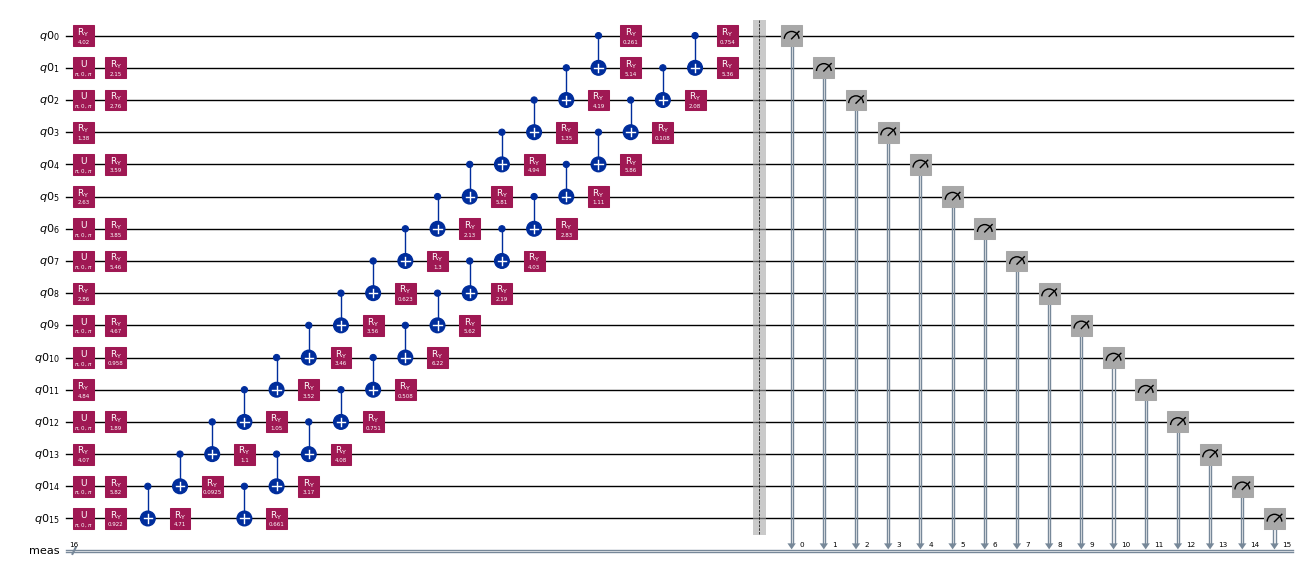

In [12]:
circuit_ra.measure_all()
circuit_ra.decompose(reps=2).draw("mpl", scale=0.5, fold=-1)

####  Step 2: Optimize circuit for target hardware

We transpile and optimize the circuit for our target backend using a preset pass manager.

In [31]:
# Transpile for hardware

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

isa_circuit_ra = pm.run(circuit_ra)
#isa_circuit_ra.global_phase = 0 #uncomment and run, if you received a "global phase" error from backend
print(f"Gate counts for RealAmplitudes ansatz: {isa_circuit_ra.count_ops()}")

Gate counts for RealAmplitudes ansatz: OrderedDict([('sx', 124), ('rz', 109), ('cz', 30), ('measure', 16), ('barrier', 1)])


#### Step 3: Execute on target hardware

We submit the transpiled circuit to the quantum backend using the SamplerV2 primitive and collect 1024 measurement samples (shots).

In [ ]:
# Execute using Sampler

job_ra = sampler.run([isa_circuit_ra])
print(f"Job ID: {job_ra.job_id()}")

#### Step 4: Post-process and analyze results

We retrieve the results from the completed job and use the `diagonalize_fermionic_hamiltonian` function to perform the SQD analysis. We set the number of self-consistent recovery iterations to 5 and use 500 samples per batch for the classical diagonalization.

In [13]:
# Run this cell after the job is complete (using the Job ID from the previous cell).
job_ra = service.job(job_id_ra)
result_ra = job_ra.result()
pub_result_ra = result_ra[0]
bit_array_ra = pub_result_ra.data.meas

In [14]:
# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5
 
# Eigenstate solver options
num_batches = 3
samples_per_batch = 50
symmetrize_spin = True
carryover_threshold = 1e-3
max_cycle = 20

#create sci solver with options
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)


In [15]:
# List to capture intermediate results
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array_ra,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
)


Iteration 1
Iteration 2
Iteration 3


In [16]:
#plot function
def plot_sqd_results(result: SCIResult, result_history: list):
    """
    Analyzes, plots, and returns the results of an SQD experiment.

    Args:
        result: The final SCIResult object from the converged SQD calculation.
        result_history: A list of SCIResult objects from each SQD iteration.
        
    Returns:
        A tuple containing:
        - energy_errors (list): The absolute energy error at each iteration.
        - fig (matplotlib.figure.Figure): The figure object for the plots.
        - axs (numpy.ndarray): The axes objects for the subplots.
    """

    iterations = range(len(result_history))
    min_energies = [
        min(res_list, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for res_list in result_history
    ]
    energy_errors = [abs(e - exact_fci_energy) for e in min_energies]

    chem_accuracy = 0.0016

    avg_occupancies = np.sum(result.orbital_occupancies, axis=0)
    orbital_indices = range(len(avg_occupancies))
    
    final_sqd_energy = result.energy + nuclear_repulsion_energy

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(iterations, energy_errors, label="Energy Error", marker="o")
    axs[0].set_xticks(iterations)
    axs[0].set_xticklabels([i + 1 for i in iterations])
    axs[0].set_yscale("log")
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="Chemical Accuracy")
    axs[0].set_title("Ground State Energy Error vs. SQD Iterations")
    axs[0].set_xlabel("Configuration Recovery Iteration")
    axs[0].set_ylabel("Absolute Energy Error (Hartree)")
    axs[0].legend()
    axs[0].grid(True, which="both", ls="--", alpha=0.5)

    axs[1].bar(orbital_indices, avg_occupancies, width=0.8)
    axs[1].set_xticks(orbital_indices)
    axs[1].set_title("Avg. Occupancy per Spatial Orbital (Final Result)")
    axs[1].set_xlabel("Orbital Index")
    axs[1].set_ylabel("Avg. Occupancy")
    axs[1].grid(True, axis='y', linestyle='--', alpha=0.5)

    print("--- SQD Results ---")
    print(f"Exact energy: {exact_fci_energy:.5f} Ha")
    print(f"Final SQD energy: {final_sqd_energy:.5f} Ha")
    print(f"Final Absolute error: {energy_errors[-1]:.5f} Ha\n")
    
    plt.tight_layout()
    
    # Return the error data and plot objects for later use
    return energy_errors, fig, axs

# Example of how to call the function and capture the returned values:
# errors, fig, axs = plot_sqd_results(result, result_history)
# plt.show() # You would call this to display the plot


--- SQD Results ---
Exact energy: -108.59599 Ha
Final SQD energy: -108.59578 Ha
Final Absolute error: 0.00020 Ha



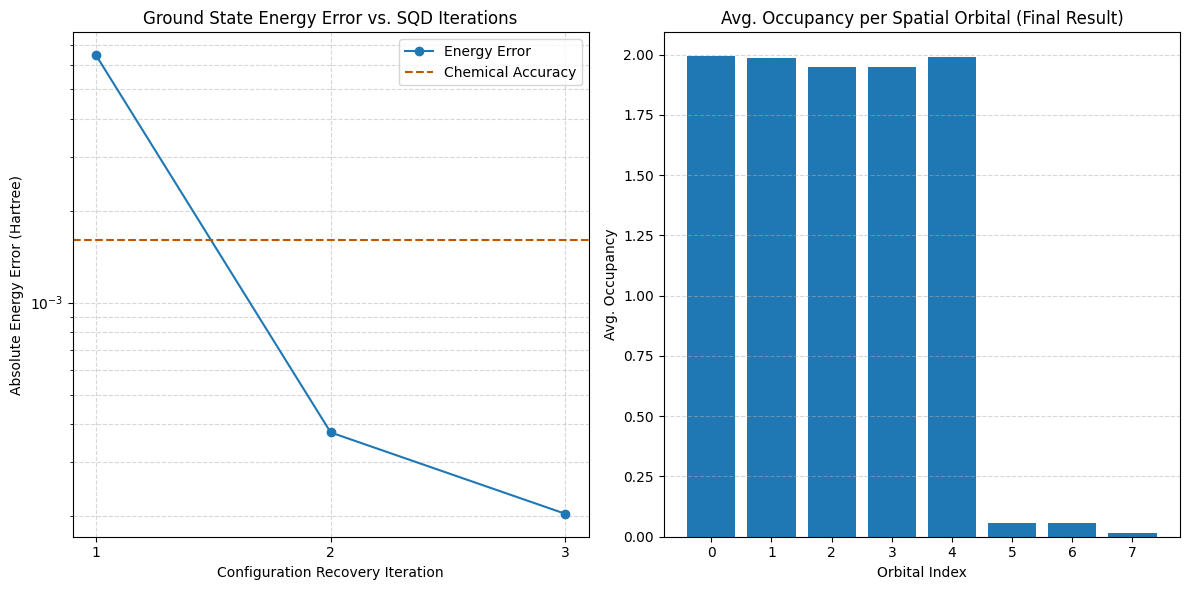

In [17]:
e_diff_ra, fig, axs = plot_sqd_results(result, result_history)
plt.show()

### 3.2. Chemistry-Inspired UCJ with a Random Initial State and Parameters

Next, we move to a more sophisticated, chemistry-inspired ansatz: the **Unitary Cluster Jastrow (UCJ)** operator ansatz. The structure of this ansatz is derived from coupled-cluster theory. It is specifically designed to capture the electron correlation effects that are crucial for accurately describing molecular systems.

Because its structure is tailored to the physics of the problem, the UCJ ansatz is expected to be much more expressive and efficient at representing the $N_2$ ground state than the generic `RealAmplitudes` circuit. To ensure a fair comparison with the previous step, we will again initialize the UCJ ansatz with randomly selected qubits and random parameters.

In [18]:
#7s ibm_fez

n_reps = 2

alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

num_params_ucj = ffsim.UCJOpSpinBalanced.n_params(
    num_orbitals, n_reps, interaction_pairs=(alpha_alpha_indices, alpha_beta_indices)
)
print(f"Number of parameters for UCJ ansatz: {num_params_ucj}")

random_params_ucj = rng.uniform(0, 2 * np.pi, num_params_ucj)

ucj_op_random = ffsim.UCJOpSpinBalanced.from_parameters(
    random_params_ucj,
    norb=num_orbitals,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

#qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit_ucj_rand = QuantumCircuit(qr_main)


random_index = rng.choice(num_orbitals, size=num_elec_a, replace=False)
for i in random_index:
    circuit_ucj_rand.x(qr_main[i])
    circuit_ucj_rand.x(qr_main[num_orbitals + i])
    
#circuit_ucj_rand.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qr_main) #try hartree-fock initial state to compare

circuit_ucj_rand.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op_random), qr_main)
circuit_ucj_rand.measure_all()

Number of parameters for UCJ ansatz: 146


#### Step 2: Optimize circuit for target hardware
The UCJ circuit is then transpiled for the target hardware.

In [20]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)


In [21]:
# Transpile and execute
isa_circuit_ucj_rand = pm.run(circuit_ucj_rand)
print(f"Gate counts for UCJ (Random) ansatz: {isa_circuit_ucj_rand.count_ops()}")

Gate counts for UCJ (Random) ansatz: OrderedDict([('sx', 1976), ('rz', 1779), ('cz', 580), ('x', 35), ('measure', 16), ('barrier', 1)])


#### Step 3: Execute on target hardware
The UCJ circuit is submitted to the sampler.

In [ ]:
#sampler = Sampler(mode=backend)

job_ucj_rand = sampler.run([isa_circuit_ucj_rand], shots=10000)
job_id_ucj_rand = job_ucj_rand.job_id()
job_id_ucj_rand

#### Step 4: Post-process and analyze results
The results from the UCJ experiment are retrieved.


In [22]:
# Run this cell after the job is complete.
job_ucj_rand = service.job(job_id_ucj_rand)
result_ucj_rand = job_ucj_rand.result()
pub_result_ucj_rand = result_ucj_rand[0]
bit_array_ucj_rand = pub_result_ucj_rand.data.meas

In [23]:

#sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array_ucj_rand,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
)

Iteration 1
Iteration 2


--- SQD Results ---
Exact energy: -108.59599 Ha
Final SQD energy: -108.59594 Ha
Final Absolute error: 0.00005 Ha



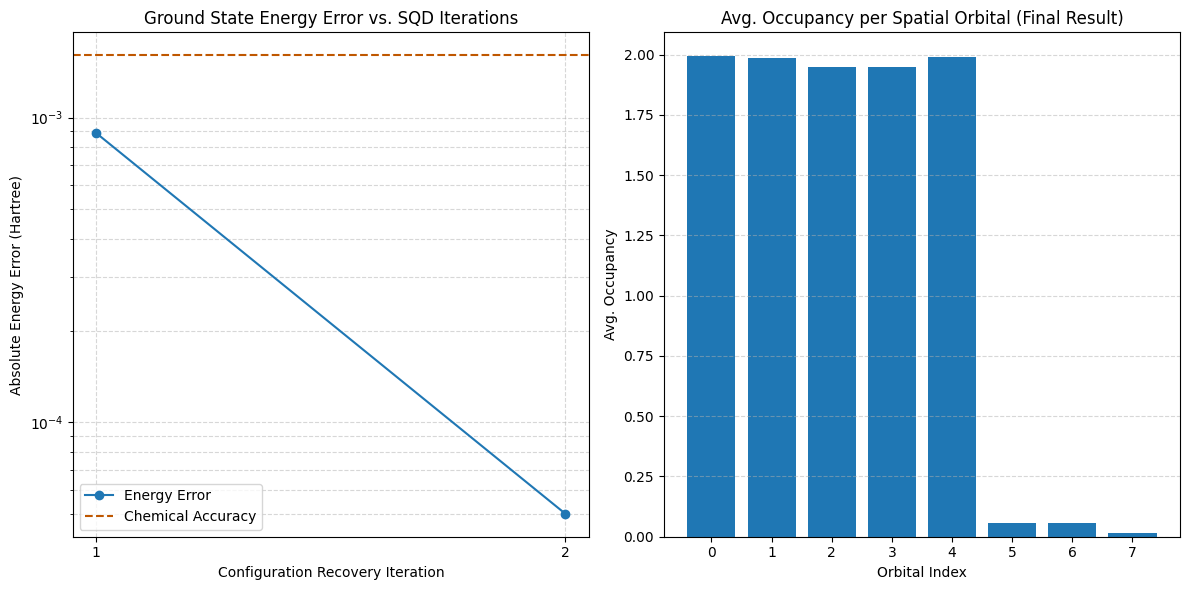

In [24]:
e_diff_rand, fig, axs = plot_sqd_results(result, result_history)
plt.show()

<div class="alert alert-info">
    
**For your Deeper Study**

So far, we used random initial initial state and parameters for both - RealAmplitude and UCJ - ansatz and computed the ground state with one calculation. 

1. Try to initialize ansatz with `Hartree Fock` state and compare it with our random initialized ansatz.
2. As SQD is a variational algorithm, can you design a feedback loop to update and optimize these initial parameters for a better final result? You can use the computed ground state energy as a cost function of this feedback loop.

</div>

### 3.3. The Informed Approach: UCJ Ansatz with CCSD Initial Parameters and Hartree-Fock State

In our most informed approach, we combine the power of the chemistry-inspired UCJ ansatz with insights from our classical calculations. Instead of using a random initial state and parameters, we will initialize the UCJ operator using the **t-amplitudes** from our earlier classical CCSD calculation. The circuit will be prepared in the Hartree-Fock state before UCJ operator is applied.

This strategy tests the central hypothesis of many variational algorithms: that a good ansatz, when guided by good initial parameters from a classical approximation, will yield the most accurate and efficient results.

#### Step 1: Map problem to quantum circuits and operators
This is the key step. We construct the `UCJOpSpinBalanced` ansatz again, but this time we initialize it using the `t1` and `t2` amplitudes from our classical CCSD calculation performed in Chapter 1, instead of random parameters.


<div class="alert alert-success">
    <h4>Exercise 4: Initialize an Informed UCJ Ansatz</h4>
    <p>Use the <code>ffsim.UCJOpSpinBalanced.from_t_amplitudes()</code> function to create the <code>ucj_op</code> below. This function directly accepts the <code>t1</code> and <code>t2</code> amplitudes from the CCSD calculation as input.</p>
    <b> Hint </b>: <a href = https://qiskit-community.github.io/ffsim/how-to-guides/qiskit-lucj.html> This ffsim tutorial </a> will be very helpful.
</div>

In [25]:

n_reps = 2

# Use interactions implementable on a square lattice
pairs_aa = [(p, p + 1) for p in range(num_orbitals - 1)]
pairs_ab = [(p, p) for p in range(num_orbitals)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    ccsd.t2,
    t1=ccsd.t1,
    n_reps=n_reps,
    interaction_pairs=(pairs_aa, pairs_ab),
    # Setting optimize=True enables the "compressed" factorization
    optimize=True,
    options=dict(maxiter=100),
)

# Construct circuit
qubits = QuantumRegister(num_qubits)
circuit_ucj_inform = QuantumCircuit(qubits)
circuit_ucj_inform.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit_ucj_inform.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit_ucj_inform.measure_all()

#### Step 2: Optimize circuit for target hardware

In [26]:
isa_circuit_ucj_inform = pm.run(circuit_ucj_inform)
print(f"Gate counts for informed UCJ: {isa_circuit_ucj_inform.count_ops()}")

Gate counts for informed UCJ: OrderedDict([('sx', 2447), ('rz', 2041), ('cz', 846), ('x', 70), ('measure', 16), ('barrier', 1)])


#### Step 3: Execute on target hardware

In [ ]:

job_ucj_inform = sampler.run([isa_circuit_ucj_inform], shots=10000)
job_id_ucj_inform = job_ucj_inform.job_id()
job_id_ucj_inform

####  Step 4: Post-process and analyze results

In [27]:
# Run this cell after the job is complete.

job_ucj_inform = service.job(job_id_ucj_inform)
result_ucj_inform = job_ucj_inform.result()
pub_result_ucj_inform = result_ucj_inform[0]
bit_array_ucj_inform = pub_result_ucj_inform.data.meas

In [28]:
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
   

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array_ucj_inform,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
)

Iteration 1
Iteration 2
Iteration 3


--- SQD Results ---
Exact energy: -108.59599 Ha
Final SQD energy: -108.59596 Ha
Final Absolute error: 0.00003 Ha



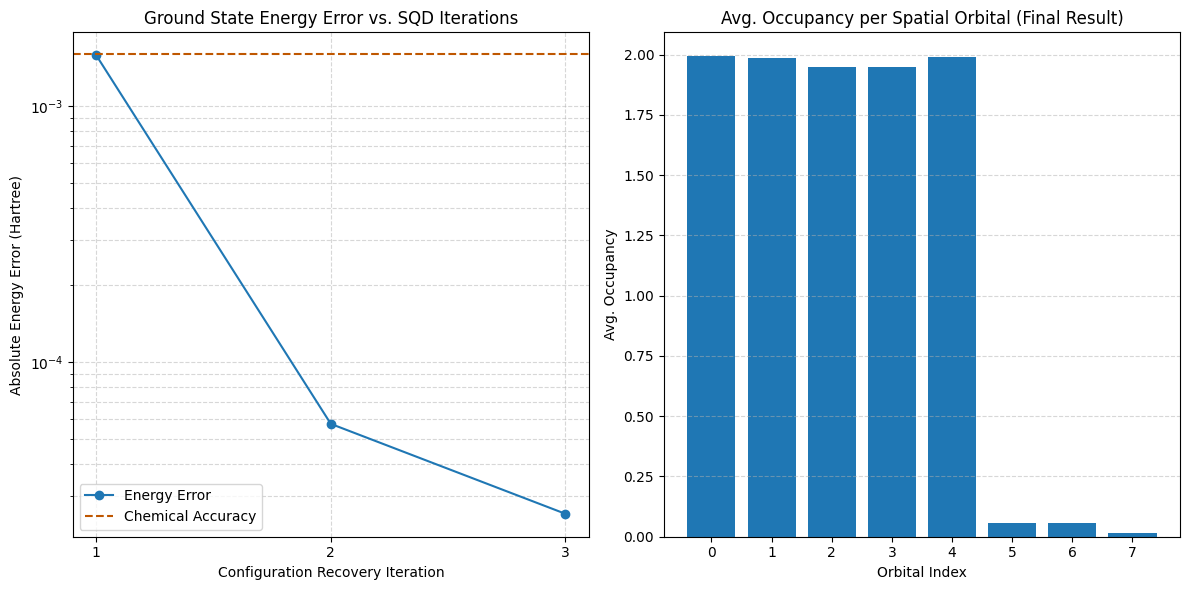

In [29]:
e_diff_ucj_inform, fig, axs = plot_sqd_results(result, result_history)
plt.show()

## 4. Sampled Krylov Quantum Diagonalization(SKQD)

We will now explore Sampled Krylov Quantum Diagonalization (SKQD).

<div class="alert alert-info">
<b>Prerequisite:</b> 
    
For a detailed theoretical background on SKQD, we highly recommend watching the video above and reviewing the material in the <b><a href="https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/skqd" target="_blank">Sample-based Krylov Quantum Diagonalization (SKQD)</a></b> chapter and <b><a href="https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-krylov-quantum-diagonalization" target="_blank">Sample-based Krylov quantum diagonalization of a fermionic lattice model</a></b> tutorial. 
    
This notebook focuses on the practical application and will skip the in-depth theoretical explanations. 

</div>


The core idea of SKQD is as follows:
1.  Select a base sate: We start with the Hartree-Fock state, the fundamental reference for our chemistry problem.
2.  Time evolution: We apply the time-evolution operator $U=e^{iHt}$ to this state. For a small, fixed time `t`, this evolution creates a new state from which we will sample. 
4.  New sampling run: We execute this new, evolved circuit on the quantum computer to obtain a new set of measurement samples (bitstrings).
5.  Final diagonalization: We perform SQD post-processing using these new samples to calculate a final ground state energy.

<details>
<summary>(power) Krylov subspace detailed:</summary>
    
The power Krylov subspace is a linear subspace spanned by a set of vectors generated by repeatedly applying a matrix, such as the Hamiltonian ($H$), to an initial reference state ($|\psi\rangle$). This can be written as:

$$\mathcal{K}_P^r = \text{span}\left\{ |\psi\rangle, H|\psi\rangle, H^2|\psi\rangle, \dots, H^{r-1}|\psi\rangle \right\}$$

Since $H$ is not a unitary operator, this power Krylov space ($\mathcal{K}_P^r$) cannot be directly generated on a quantum computer. Instead, SKQD uses a related unitary Krylov space ($\mathcal{K}_U^r$), created using the time-evolution operator $U = e^{-iHt}$:
$$\mathcal{K}_U^r = \text{span}\left\{ |\psi\rangle, U|\psi\rangle, U^2|\psi\rangle, \dots, U^{r-1}|\psi\rangle \right\}$$

This unitary operation can be approximated on a quantum computer using `Trotterization`. This method breaks down the complex time-evolution operator into a sequence of smaller, more manageable gate operations. SKQD uses a fixed Krylov dimension to determine the size of this subspace.
</details>
</br>


<div class="alert alert-warning">
    
**Note on using Krylov method for chemistry problems**

The Krylov method uses a "Trotterization" to generate a quantum circuit for a Krylov subspace, which results in a huge quantum circuit, especially in depth. Here we introduce you to how to use this `SKQD` in chemical problem as a `learning` - learn and see its potential. 

</div>

<div class="alert alert-success">
    <h4>Exercise 5: Construct and Analyze the SKQD Circuits</h4>
    <p>For the first part of our SKQD implementation, we will focus on generating the necessary quantum circuits and analyzing their size</p>
    <p><b>Part A</b>: Create the Circuit Generation Function</b></p>
    <p>In the code cell below, complete the function <code>create_skqd_circuits</code>. This function should take the Krylov dimension (<code>dim</code>) as input and return a list of quantum circuits, where each circuit corresponds to a different time evolution <i>t = i * dt</i>.</p>
    <p>Steps:</p>
    <ul>
        <li>(Done) Inside the function, loop from <code>i = 0</code> to <code>dim-1</code>.</li>
        <li>(Done) In each loop iteration, create a <code>QuantumCircuit</code>.</li>
        <li>Initialize the circuit in the Hartree-Fock state using <code>ffsim.qiskit.PrepareHartreeFockJW</code>.</li>
        <li>Create a time evolution gate (evol_gate) using Qiskit's <code>PauliEvolutionGate</code>. Use the <code>LieTrotter</code> synthesis method with 2 repetitions (<code>reps=2</code>) for the Trotterization. Add this gate to your circuit.</li>
        <li>(Done) Add measurements to all qubits and append the completed circuit to the list.</li>
    </ul>
    <p><b>Part B</b>: Analyze Circuit Depth</p>
    <p>After defining your function, use it to generate the circuits for a Krylov dimension (max_krylov_dim)  of 4 with dt = 1. Then, transpile the deepest circuit (the last one in the list) and print its gate counts to see the resource requirements, after transpile. Compare this to the gate counts from the SQD ansatzes.</p>
</div>

In [42]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
def create_skqd_circuits(dim: int, qr: QuantumRegister, ham_op: SparsePauliOp, time_step: float, norb: int, nelec: tuple) -> list[QuantumCircuit]:
    """
    Constructs a list of quantum circuits for an SKQD experiment.
    Args:
        dim: The Krylov subspace dimension.
        qr: The QuantumRegister to build the circuits on.
        ham_op: The qubit Hamiltonian operator for time evolution.
        time_step: The time step (dt) for the evolution gate.
        norb: The number of spatial orbitals.
        nelec: A tuple containing the number of alpha and beta electrons.
    Returns:
        A list of quantum circuits, each evolved to a different time t = i * dt.
    """
    circuits = []
    # --- Part A: Your Code Here ---
    for i in range(dim):
        t = time_step * i
        circuit_i = QuantumCircuit(qr)
        circuit_i.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qr)
        if t > 0:
            evol_gate = PauliEvolutionGate(ham_op, time=t, synthesis=LieTrotter(reps=2))
            circuit_i.append(evol_gate, qr)
        circuit_i.measure_all()
        circuits.append(circuit_i)
    # --- End Part A ---
    return circuits

In [43]:
    
# --- Part B: Your Code Here ---
# Define parameters for this analysis
max_krylov_dim_for_analysis = 4
dt = 1
# Generate the circuits
test_skqd_circuits = create_skqd_circuits(
    dim=max_krylov_dim_for_analysis,
    qr=qr_main,
    ham_op=hamiltonian_op,
    time_step=dt,
    norb=num_orbitals,
    nelec=nelec
)
# Transpile the deepest circuit
deepest_skqd_circuit = test_skqd_circuits[-1]
isa_deepest_skqd = pm.run(deepest_skqd_circuit)
# Print the gate counts and compare
print(f"Gate counts for the deepest SKQD circuit (k=2): {isa_deepest_skqd.count_ops()}")
print(f"Gate counts for RealAmplitudes ansatz: {isa_circuit_ra.count_ops()}")
print(f"Gate counts for informed UCJ ansatz: {isa_circuit_ucj_inform.count_ops()}")
# --- End Part B ---

Gate counts for the deepest SKQD circuit (k=2): OrderedDict([('sx', 57238), ('cz', 32288), ('rz', 28485), ('x', 1893), ('measure', 16), ('barrier', 1)])
Gate counts for RealAmplitudes ansatz: OrderedDict([('sx', 124), ('rz', 109), ('cz', 30), ('measure', 16), ('barrier', 1)])
Gate counts for informed UCJ ansatz: OrderedDict([('sx', 2447), ('rz', 2041), ('cz', 846), ('x', 70), ('measure', 16), ('barrier', 1)])


We have now completed the core function for creating SKQD circuits and analyzing their depth. Now it's time to use this function as a building block to complete the full SKQD workflow.
In the following Exercise 6, we will call this function to iteratively run experiment for various Krylov dimensions and build the entire routine to calculate the final ground state energy.

<div class="alert alert-success">
    <h4>Exercise 6: Run the Full SKQD Workflow</h4>
    <p>Now that you have a function to generate circuits, it's time to combine everything. This final exercise is split into two parts: submitting the quantum jobs, and then retrieving and processing the results.</p>
    <p><b>Part A</b>: Complete SKQD Circutis / Submit Quantum Jobs and Collect Job IDs</p>
    <p>First, we will loop through the Krylov dimensions, create the circuits, and submit them as jobs. We will then store the unique ID for each job so we can retrieve the results later.</p>
    <p>Steps</p>
    <ol>
        <li>Create an empty list called <code>job_ids_skqd</code> to store the job IDs.</li>
        <li>Loop through the Krylov dimensions from 1 to 3.</li>
        <li>Inside the loop, call your <code>create_skqd_circuits</code> function from Exercise 5.</li>
        <li>Transpile the circuits using the preset pass manager (<code>pm</code>).</li>
        <li>Submit the jobs to the sampler, adjusting the shots for each dimension (<code>shots=int(10000/dim)</code>) to guarantee same sampling numbers.</li>
        <li>Get the job ID from the submitted job and append it to your <code>job_ids_skqd</code> list. Print the ID so you know the job has been submitted.</li>
    </ol>
</div>

In [ ]:
# --- SKQD Main Loop: Part A ---
max_krylov_dim = 4
dt = 0.00046
krylov_dims = range(1, max_krylov_dim + 1)

# 1. Create a list to store job IDs
job_ids_skqd = []

print("--- Submitting SKQD jobs for different Krylov dimensions ---")
# --- Your Code Here ---
for dim in krylov_dims:
    print(f"\nSubmitting job for Krylov Dimension = {dim}...")
    # 2. Create the circuits for the current dimension
    circuits = create_skqd_circuits(
        dim=dim, qr=qr_main, ham_op=hamiltonian_op, time_step=dt,
        norb=num_orbitals, nelec=nelec
    )
    # 3. Transpile the circuits
    isa_circuits = pm.run(circuits)
    # 4. Submit the job
    # NOTE: This cell will run jobs on your selected backend.
    # If using real hardware, this may take time.
    job = sampler.run(isa_circuits, shots=int(10000/dim))
    # 5. Get the job ID and store it
    job_ids_skqd.append(job.job_id())
# --- End Your Code ---
print("\n--- All jobs submitted ---")

print("Collected Job IDs:", job_ids_skqd)


<div class="alert alert-info">
    <p>Once your jobs have completed (you can check their status in your IBM Quantum dashboard), you can proceed with Part B.</p>
</div>

<div class="alert alert-success">
    <p><b>Part B:</b> Retrieve Results and Post-Process</p>
    <p>Now, we will loop through the list of job IDs we just collected. For each ID, we will retrieve the corresponding job result, process the data, and calculate the final energy.</p>
    <p>Steps</p>
    <ol>
        <li>Create empty lists for <code>final_energies</code> and <code>histories</code>.</li>
        <li>Loop through your <code>job_ids_skqd</code> list (using <code>enumerate</code> is helpful to keep track of the dimension).</li>
        <li>Inside the loop, use <code>service.job(job_id)</code> to retrieve the job object.</li>
        <li>Get the result from the job and combine the measurement data into a single <code>BitArray</code>.</li>
        <li>Call the <code>diagonalize_fermionic_hamiltonian</code> function with the combined data to perform the final analysis.</li>
        <li>Store the final converged energy and print it.</li>
    </ol>
</div>

In [50]:
# --- SKQD Main Loop: Part B ---

final_energies = []
histories = []
print("--- Retrieving results and post processing ---")
# --- Your Code Here ---
for i, job_id in enumerate(job_ids_skqd):
    dim = krylov_dims[i]
    result_history = []

    
    # 1. Retrieve the job and its result
    job = service.job(job_id)
    result = job.result()
    
    # 2. Combine measurement results
    bit_array = BitArray.concatenate_shots([p.data.meas for p in result])
    print(f"  Collected {bit_array.num_shots} total samples.")
    
    # 3. Perform the final diagonalization
    sqd_result = diagonalize_fermionic_hamiltonian(
        hcore, eri, bit_array,
        samples_per_batch=samples_per_batch,
        norb=num_orbitals, nelec=nelec,
        num_batches=num_batches, max_iterations=max_iterations,
        sci_solver=sci_solver, callback=callback,
    )
    histories.append(result_history)
    
    # 4. Store and print the final converged energy
    final_energy = sqd_result.energy + nuclear_repulsion_energy
    final_energies.append(final_energy)
    
    print(f"  Converged Energy for dimension {dim}: {final_energy:.5f} Ha")

--- Retrieving results and post processing ---
  Collected 10000 total samples.
Iteration 1
Iteration 2
  Converged Energy for dimension 1: -108.50794 Ha
  Collected 10000 total samples.
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
  Converged Energy for dimension 2: -108.59595 Ha
  Collected 9999 total samples.
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
  Converged Energy for dimension 3: -108.59589 Ha
  Collected 10000 total samples.
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
  Converged Energy for dimension 4: -108.59570 Ha


Now, plot results by `Krylov Subspace Dimensions`

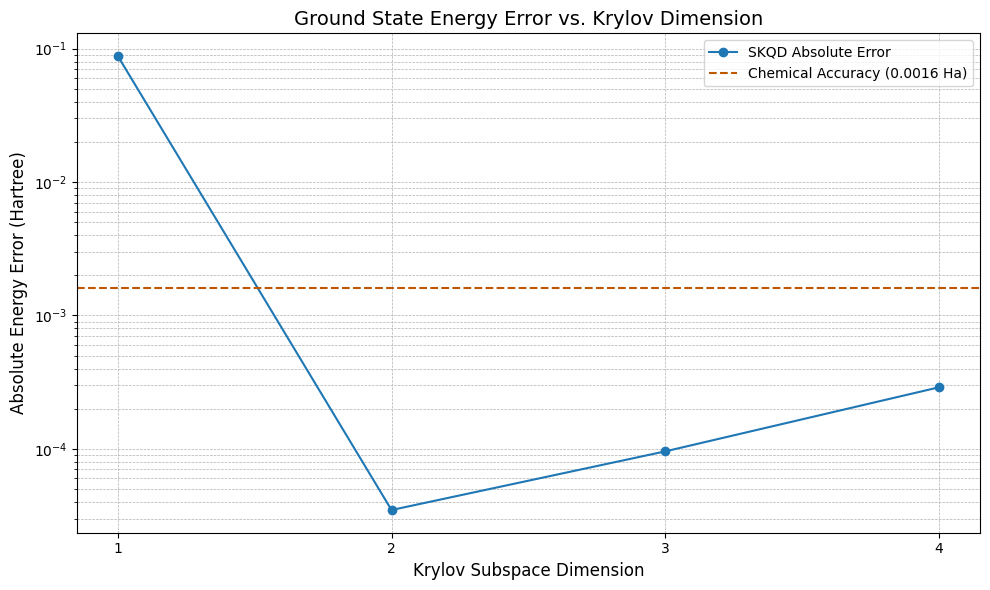

In [51]:
# --- 1. Calculate the absolute error ---
# Calculate the absolute difference between each calculated energy and the exact FCI energy.
absolute_errors = [abs(energy - exact_fci_energy) for energy in final_energies]

# Define the chemical accuracy threshold in Hartree
chem_accuracy = 0.0016

# --- 2. Plotting the Error ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the absolute error vs. Krylov dimension
ax.plot(
    list(krylov_dims),
    absolute_errors,
    marker='o',
    linestyle='-',
    label="SKQD Absolute Error"
)

# Plot the chemical accuracy reference line
ax.axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label=f"Chemical Accuracy ({chem_accuracy} Ha)"
)

# --- 3. Formatting and Labels ---
# Set the y-axis to a logarithmic scale
ax.set_yscale("log")

ax.set_xlabel("Krylov Subspace Dimension", fontsize=12)
ax.set_ylabel("Absolute Energy Error (Hartree)", fontsize=12)
ax.set_title("Ground State Energy Error vs. Krylov Dimension", fontsize=14)
ax.set_xticks(list(krylov_dims))
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In [52]:
#save lowest SKQD result for plotting

history = histories[np.argmin(final_energies)]

min_energies = [
        min(res_list, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for res_list in history
    ]
e_diff_skqd = [abs(e - exact_fci_energy) for e in min_energies]

## 5. Compare Results

<div class="alert alert-success">
    <h4>Congratulations! &#127881;</h4>
    You have successfully calculated the ground state energy of the $N_2$ molecule using advanced quantum algorithms. You've seen firsthand how a diagonalization-based quantum approach, combining insights from classical chemistry with the power of quantum sampling, can achieve meaningful accuracy.
</div>

In this notebook, we explored two powerful quantum methods, SQD and SKQD, to determine the ground state energy of the $N_2$ molecule using different strategies. The results, summarized in the comparison plot below, clearly demonstrate the strengths and trade-offs of each approach, leading to a compelling conclusion: for quantum chemistry simulations on near-term devices, a physically-motivated ansatz initialized with classical chemical insight potentially provides an advantage.

Our investigation showed a systematic improvement in accuracy as we refined our SQD strategy:

1.  Baseline: The generic `RealAmplitudes` ansatz established a performance baseline. While it demonstrated convergence, its final error was the largest among all approaches, highlighting the limitations of a hardware-efficient but chemically unaware ansatz.


2.  Improved Ansatz Structure: Switching to the chemistry-inspired `UCJ` ansatz, even with random parameters, yielded an improvement, converging to a result well within chemical accuracy. This demonstrates the power of choosing an ansatz structure that reflects the underlying physics of the problem 

3.  The Informed Approach: Initializing the `UCJ` ansatz with t-amplitudes from a classical CCSD calculation also achieved a high degree of accuracy. This "informed" approach confirms that quantum algorithms can perform well when their state preparation is guided by classical approximations.

4.  Another Way of Good Sampling: Despite requiring deeper circuits, SKQD produced a result that also achieved chemical accuracy, and in this specific run, had the lowest final error. This showcases it as a powerful, non-variational alternative.

Ultimately, all chemistry-inspired methods (UCJ with random or informed parameters, and SKQD) far outperformed the generic ansatz. The small differences in final energy between them are likely within the statistical noise of the device and limitation of a simple basis-set, confirming that multiple pathways exist to achieve high accuracy in quantum chemistry simulations.


### Comparison Plot

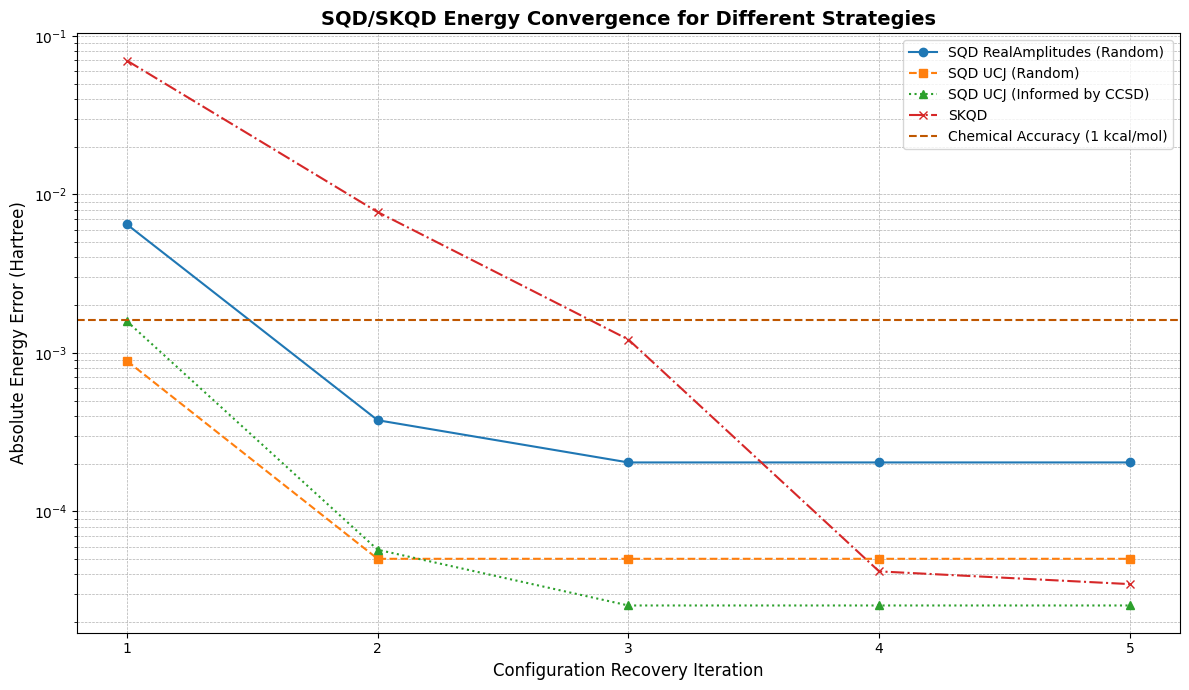

In [53]:
# --- Configuration ---
plot_data = [
    {
        "label": "SQD RealAmplitudes (Random)",
        "errors": e_diff_ra,
        "marker": "o",
        "linestyle": "-",
        "color": "C0"
    },
    {
        "label": "SQD UCJ (Random)",
        "errors": e_diff_rand,
        "marker": "s",
        "linestyle": "--",
        "color": "C1"
    },
    {
        "label": "SQD UCJ (Informed by CCSD)",
        "errors": e_diff_ucj_inform,
        "marker": "^",
        "linestyle": ":",
        "color": "C2"
    },
    {
        "label": "SKQD",
        "errors": e_diff_skqd,
        "marker": "x",
        "linestyle": "-.",
        "color": "C3"
    }
]
MAX_ITERATIONS = 5
CHEM_ACCURACY = 0.0016  # 1 kcal/mol

# --- Helper Function for Data Padding ---
def pad_data(error_list, target_length):
    """Pads an error list with its last value to a target length."""
    last_value = error_list[-1] if error_list else 0
    padding = [last_value] * (target_length - len(error_list))
    return error_list + padding

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 7))
for data in plot_data:
    padded_errors = pad_data(data["errors"], MAX_ITERATIONS)
    ax.plot(
        range(MAX_ITERATIONS),
        padded_errors,
        label=data["label"],
        marker=data["marker"],
        linestyle=data["linestyle"],
        color=data["color"]
    )

ax.axhline(
    y=CHEM_ACCURACY,
    color="#BF5700",  # A distinct color
    linestyle="--",
    label="Chemical Accuracy (1 kcal/mol)"
)
# --- Formatting and Labels ---
ax.set_yscale("log")
ax.set_ylabel("Absolute Energy Error (Hartree)", fontsize=12)
ax.set_xlabel("Configuration Recovery Iteration", fontsize=12)
ax.set_title("SQD/SKQD Energy Convergence for Different Strategies", fontsize=14, fontweight='bold')
ax.set_xticks(range(MAX_ITERATIONS))
ax.set_xticklabels([i + 1 for i in range(MAX_ITERATIONS)]) # Label iterations starting from 1
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
    
**For your Deeper Study**

Here, our final plot was made by using a real backend result. How would things change if we were to use an ideal simulator with a sto-3g (or even sto-6g) basis set — one of the simplest available? It will likely give you a different result. We encourage you to think about the reasons why.

If you have a computer with sufficient memory (more than 64GB), we recommend you try a different basis set—`6-31g`—with both an ideal simulator and a real backend and compare our different strategies. Please be sure to also compare the new CASCI energy computed for that basis set.


**Questions for Further Exploration**

- Ansatz Suitability: Why does the UCJ ansatz, even with random parameters, generally outperform the hardware-efficient RealAmplitudes ansatz for this chemistry problem? What structural features of UCJ make it more suitable for capturing electron correlation?
- Overall Efficiency: The "informed" UCJ was the most accurate (but can differ by runs). Was it the most efficient overall? Consider the total computational cost, including the classical CCSD calculation time plus the quantum execution time. 
- SQD vs. SKQD: The SKQD circuit was noted to be very deep. Under what conditions might SKQD be a better choice than a variational method like SQD? 
- Problem Scaling: How would the resource requirements (qubits, circuit depth) and the impact of noise change if you were to simulate a slightly larger molecule, like water ($H_2O$), using the sto-6g basis set?
- Subspace Insights: Beyond just the final energy, what can the sampled bitstrings tell you about the nature of the molecule's ground state? How does the distribution of the most frequent samples from the "informed" UCJ run differ from the RealAmplitudes run?
</div>

**Created by:** Sophy Shin

**Reviewed by:**  Kevin Sung, Katie McCormick



<div class="alert alert-info">

© IBM Corp., 2025

This is licensed under the [Creative Commons Attribution-ShareAlike 4.0  International (CC BY-SA 4.0)](https://github.com/Qiskit/documentation/blob/main/LICENSE-DOCS)
</div>